# Why Quantize Ai Models ?


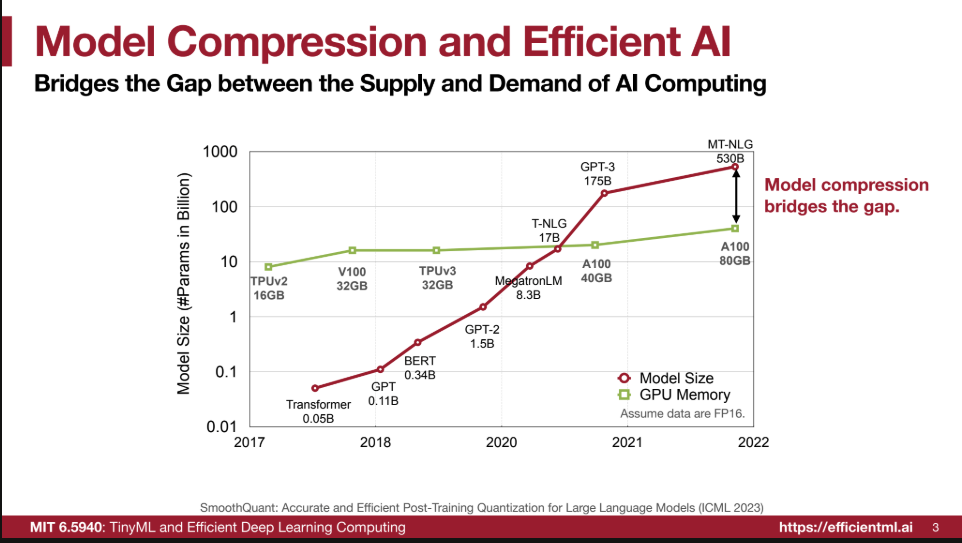

# Benefits of Quantization 

## 1. Decrease Vram requirement 
## 2. Decrease Model size ( helpful in serverless / Edge use cases )
## 3. Generally Training Free Approach ( !Most important )

# Key Idea behind Quantization 

# Decreasing Precision ( Float32 / float16 to int8 / float8 / int4 / fp4 )

# Benefits 

## 1. Smaller model size 

## 2. Faster Inference speeds

# Visual examples of quantization 

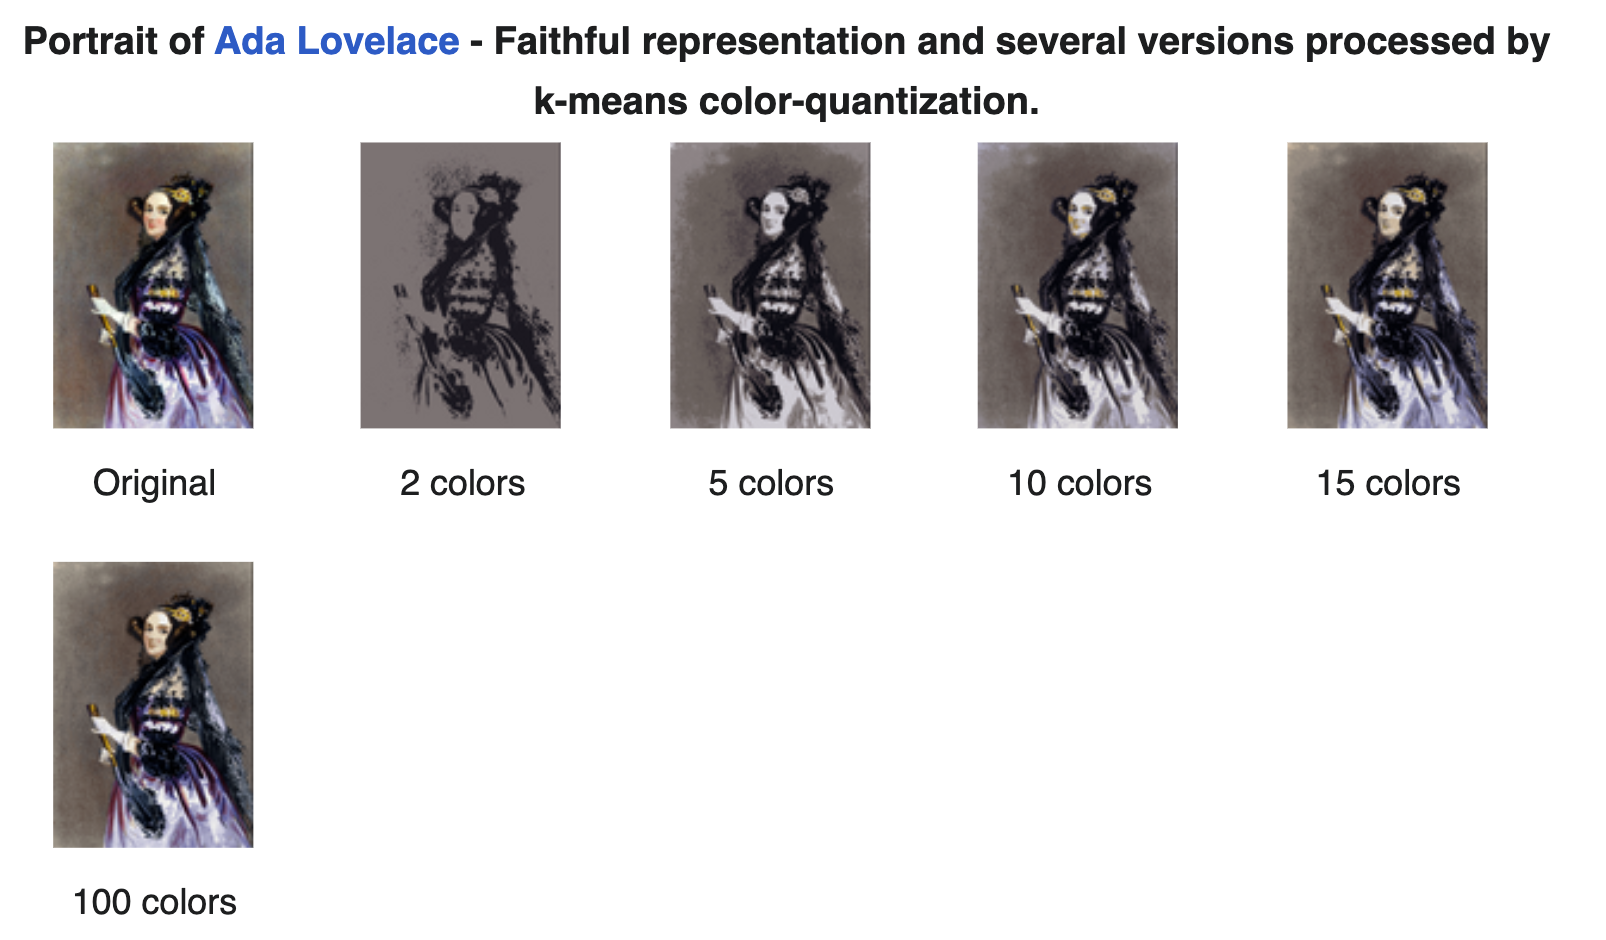


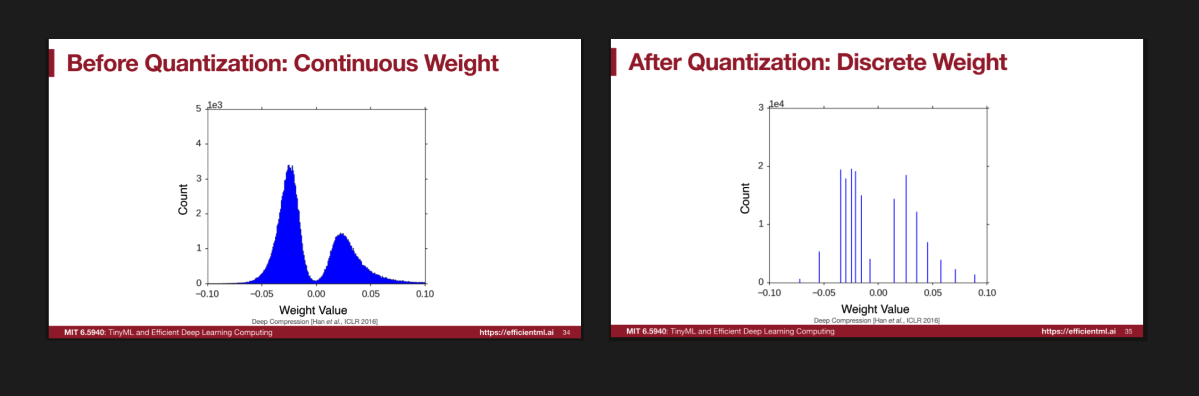

# Most common Quantization Techniques

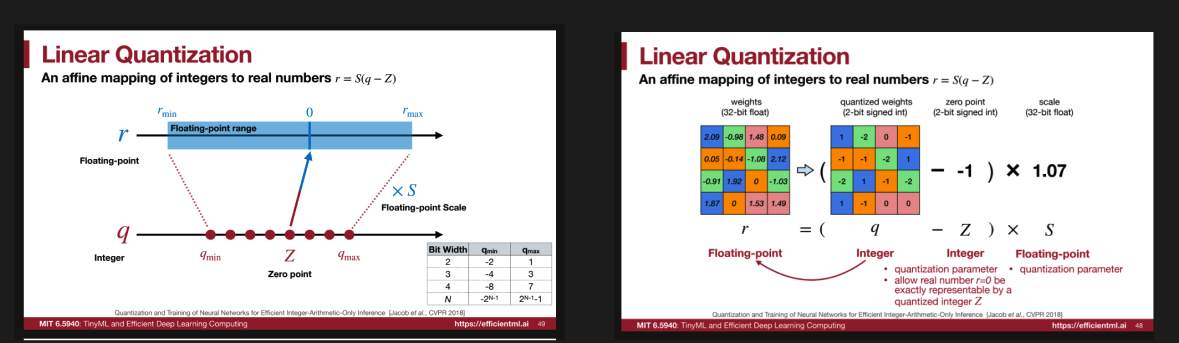

In [1]:
## Loop To Quantize Any Model 


def patch_linearlayers(model, fct):
    for name, layer in model.named_children():
        if isinstance(layer, torch.nn.Linear):
            setattr(model, name, fct(layer))
        else:
            patch_linearlayers(layer, fct)

# Deep Dive Implementation of Svd Quant 



In [2]:
import torch
import torch.nn as nn


def quantize_4b_blocks(tensor, block_size, q_bit=4):
    """
    Quantizes the tensor in blocks into 4-bit values and packs two values per byte.
    
    Args:
        tensor (torch.Tensor): The tensor to quantize.
        block_size (int): Number of elements per block (must be even for 4-bit packing).
        q_bit (int): Bit width for quantization (should be 4 for this function).
        
    Returns:
        packed (torch.ByteTensor): Tensor containing the packed 4-bit values.
        scales (torch.Tensor): Per-block scaling factors.
        original_shape (torch.Size): The original shape of the tensor.
    """
    if q_bit != 4:
        raise ValueError("This function is specifically for 4-bit quantization.")
    
    # For 4-bit symmetric quantization (e.g. values in [-7, 7])
    qmax = 2**(q_bit-1) - 1  # 2^(4-1)-1 = 7
    original_shape = tensor.shape
    flattened = tensor.flatten()
    num_elements = flattened.numel()
    
    # Ensure the total number of elements is divisible by block_size.
    if num_elements % block_size != 0:
        raise ValueError(f"Tensor size {num_elements} must be divisible by block_size {block_size}")
    
    # For packing into 4-bit (2 values per byte), we require block_size to be even.
    if block_size % 2 != 0:
        raise ValueError("For 4-bit quantization, block_size must be even to allow packing pairs.")
    
    # Reshape into blocks: shape (num_blocks, block_size)
    blocks = flattened.view(-1, block_size)
    
    # Compute per‑block maximum absolute values (avoid division by zero)
    max_abs = torch.max(torch.abs(blocks), dim=1).values
    max_abs = torch.clamp(max_abs, min=1e-8)
    scales = max_abs / qmax  # Scale factor per block
    
    # Quantize: scale the blocks, round, and clamp to [-qmax, qmax]
    scaled_blocks = blocks / scales.unsqueeze(1)  # Broadcasting the scale per block
    quantized = torch.round(scaled_blocks).clamp(-qmax, qmax).to(torch.int8)
    
    # For blocks that are (nearly) all zeros, set scale and quantized values to zero.
    zero_mask = (max_abs < 1e-8)
    scales[zero_mask] = 0.0
    quantized[zero_mask] = 0

    # Convert signed 4-bit numbers to an unsigned representation.
    # For a 4-bit two's complement representation: if value is negative, add 16.
    quantized_unsigned = torch.where(quantized < 0, quantized + 16, quantized).to(torch.uint8)
    
    # Pack every two 4-bit values into one byte.
    # First, reshape the last dimension to pair up values: shape (num_blocks, block_size//2, 2)
    blocks_reshaped = quantized_unsigned.view(-1, block_size // 2, 2)
    # Pack: first nibble goes into the high 4 bits, second nibble into the low 4 bits.
    packed = (blocks_reshaped[:, :, 0] << 4) | blocks_reshaped[:, :, 1]  # shape: (num_blocks, block_size//2)
    
    return packed, scales, original_shape

def dequantize_4b_blocks(packed, scales, block_size, original_shape):
    """
    Unpacks and dequantizes the 4-bit packed tensor.
    
    Args:
        packed (torch.ByteTensor): Packed tensor of shape (num_blocks, block_size//2)
        scales (torch.Tensor): Per-block scales.
        block_size (int): The original block size (must be even).
        original_shape (torch.Size): The original shape of the tensor.
    
    Returns:
        dequantized (torch.Tensor): The dequantized tensor with original shape.
    """
    num_blocks = packed.shape[0]
    
    # Unpack: extract high and low nibbles from each byte.
    high = (packed >> 4) & 0xF  # High 4 bits
    low  = packed & 0xF         # Low 4 bits
    
    # Reassemble the two nibbles back into a tensor of shape (num_blocks, block_size)
    # by interleaving the high and low parts.
    unpacked = torch.stack([high, low], dim=2).reshape(num_blocks, block_size)
    
    # Convert from unsigned (0–15) back to signed 4-bit representation.
    # For values 8 and above, subtract 16.
    signed_unpacked = torch.where(unpacked >= 8, unpacked - 16, unpacked).to(torch.int8)
    
    # Dequantize by multiplying with the per‑block scales.
    dequantized_blocks = signed_unpacked* scales.unsqueeze(1)
    
    return dequantized_blocks.view(original_shape)

# An example modified model that uses 4-bit quantization for the "remainder".
class SDV_FC_4b(nn.Module):
    def __init__(self, l1, l2, bias, remainder, block_size, q_bit=4):
        """
        Initializes the model.
        
        Args:
            l1, l2, bias: Standard parameters.
            remainder: The tensor to be quantized in 4-bit.
            block_size: The block size used for per-block quantization.
            q_bit: Should be 4.
        """
        super(SDV_FC_4b, self).__init__()
        self.l1 = nn.Parameter(l1.clone())
        self.l2 = nn.Parameter(l2.clone())
        self.bias=None
        if bias!=None:
            self.bias = nn.Parameter(bias.clone())
        
        # Store input features dimension
        self.in_features = remainder.size(1)
        self.out_features = remainder.size(0)
        
        self.block_size = block_size
        
        if q_bit != 4:
            raise ValueError("This model is set up for 4-bit quantization only.")
        
        # Quantize the remainder using 4-bit quantization.
        quantized_remainder, scales, original_shape = quantize_4b_blocks(remainder, block_size, q_bit)
        # Save the packed quantized tensor and scales as buffers.
        self.register_buffer('quantized_remainder', quantized_remainder)
        self.register_buffer('scales', scales)
        # Save the original shape as an attribute (for dequantization)
        self.original_shape = original_shape
        
        # Optionally delete the original tensors to free memory.
        del l1, l2, bias, remainder
        
    def forward(self, x):
        # Compute the standard low-rank output.
        standard_out = x @ self.l2.t() @ self.l1.t()
        
        # Dequantize the packed remainder.
        dequantized_remainder = dequantize_4b_blocks(
            self.quantized_remainder, self.scales, self.block_size, self.original_shape
        )
        remainder_out = x @ dequantized_remainder.t()
        
        # Combine outputs along with bias.

        out = remainder_out + standard_out
        if self.bias!=None:
           out+=self.bias 
        return out
    @property
    def weight(self):
        """
        Property that returns the dequantized weight tensor.
        This ensures compatibility with code that expects a .weight attribute.
        """
        return dequantize_4b_blocks(
            self.quantized_remainder, self.scales, self.block_size, self.original_shape
        )

def SDV_FC_FullyConnectedLayers(fc_weight, fc_bias, block_size=64 , q_bit=4,rank=32):
    # Compute SVD
    U, S, Vh = torch.linalg.svd(fc_weight.float(), full_matrices=False)
    
    # Verify S is sorted
    assert torch.all(S[:-1] >= S[1:]), "Singular values not sorted!"
    
    # Take components corresponding to non-zero singular values
    U_r = U[:, :rank].to(torch.float16)
    S_r = S[:rank].to(torch.float16)
    V_r = Vh[:rank, :].to(torch.float16)
    
    # Create scaled matrices
    l1 = U_r @ torch.diag(S_r)
    l2 = V_r
    remainder = fc_weight-l1 @ l2
    del U, S, Vh, fc_weight
    torch.cuda.empty_cache()  # Clear GPU cache
    gc.collect()  # Force garbage collection
    return SDV_FC_4b(l1, l2, fc_bias, remainder , block_size , q_bit)


def count_linear_layers(module):
    """Helper to count total nn.Linear layers in a module hierarchy."""
    count = 0
    for child in module.children():
        if isinstance(child, nn.Linear):
            count += 1
        else:
            count += count_linear_layers(child)
    return count

In [3]:
import torch
import torch.nn as nn
import numpy as np
import gc



def print_gpu_memory(device_index=0):
    """
    Prints GPU memory information for the specified device.
    
    Args:
        device_index (int): Index of the GPU device to check (default is 0)
    """
    if torch.cuda.is_available():
        try:
            # Get GPU properties and memory info
            total_memory = torch.cuda.get_device_properties(device_index).total_memory
            current_memory = torch.cuda.memory_allocated(device_index)
            free_memory = total_memory - current_memory
            
            # Convert to GB and print
            print(f"GPU {device_index} Memory Stats:")
            print(f"Total GPU Memory: {total_memory / 1024**3:.2f} GB")
            print(f"Used GPU Memory: {current_memory / 1024**3:.2f} GB")
            print(f"Free GPU Memory: {free_memory / 1024**3:.2f} GB")
        except RuntimeError as e:
            print(f"Error accessing GPU {device_index}: {str(e)}")
    else:
        print("No GPU available")

# Example usage
print_gpu_memory()  # Will check GPU 0 by default
# print_gpu_memory(1)  # To check a different GPU if available
# Assuming all your previous code is defined above this point

def test_quantization_dequantization():
    """Test the quantization and dequantization functions"""
    # Create a sample tensor
    torch.manual_seed(42)
    tensor = torch.randn(16, 32)  # 512 elements total
    block_size = 64
    
    # Quantize
    packed, scales, original_shape = quantize_4b_blocks(tensor, block_size)
    
    # Dequantize
    recovered = dequantize_4b_blocks(packed, scales, block_size, original_shape)
    
    # Calculate error
    mse = torch.mean((tensor - recovered) ** 2)
    max_abs_error = torch.max(torch.abs(tensor - recovered))
    
    print("Quantization Test Results:")
    print(f"MSE: {mse.item():.6f}")
    print(f"Max Absolute Error: {max_abs_error.item():.6f}")
    
    # Check shapes
    assert recovered.shape == tensor.shape, "Shape mismatch after dequantization"
    assert packed.dtype == torch.uint8, "Packed tensor should be uint8"
    assert packed.shape[1] == block_size // 2, "Incorrect packed dimension"

def test_model_accuracy():
    """Test the SDV_FC_4b model against a standard Linear layer"""
    torch.manual_seed(42)
    
    # Create a sample linear layer
    in_features = 128
    out_features = 64
    original_linear = nn.Linear(in_features, out_features)
    original_linear.weight.data = original_linear.weight.data.to(torch.float16)
    original_linear.bias.data = original_linear.bias.data.to(torch.float16)
    
    # Create test input
    batch_size = 32
    x = torch.randn(batch_size, in_features).to(torch.float16)
    
    # Get original output
    with torch.no_grad():
        original_output = original_linear(x)
    
    # Convert to our quantized model
    quantized_model = SDV_FC_FullyConnectedLayers(
        
        fc_weight=original_linear.weight.data,
        fc_bias=original_linear.bias.data,
        
    )
    
    # Get quantized model output
    with torch.no_grad():
        quantized_output = quantized_model(x)
    
    # Calculate errors
    mse = torch.mean((original_output - quantized_output) ** 2)
    max_abs_error = torch.max(torch.abs(original_output - quantized_output))
    
    print("\nModel Accuracy Test Results:")
    print(f"MSE: {mse.item():.6f}")
    print(f"Max Absolute Error: {max_abs_error.item():.6f}")
    
    # Test weight property
    recovered_weight = quantized_model.weight
    original_weight = original_linear.weight.data
    weight_mse = torch.mean((original_weight - recovered_weight) ** 2)
    
    print(f"Weight Reconstruction MSE: {weight_mse.item():.6f}")

    print("\nExample Original Output (first 10 values):", original_output[0][0:10])
    print("Example Quantized Output (first 10 values):", quantized_output[0][0:10])

def run_all_tests():
    print("Running all tests...\n")
    test_quantization_dequantization()
    test_model_accuracy()
    
    print("\nAll tests completed!")

if __name__ == "__main__":
    # Run on CPU for simplicity, but you could add .cuda() calls to test on GPU
    run_all_tests()

GPU 0 Memory Stats:
Total GPU Memory: 15.60 GB
Used GPU Memory: 0.00 GB
Free GPU Memory: 15.60 GB
Running all tests...

Quantization Test Results:
MSE: 0.009689
Max Absolute Error: 0.200878

Model Accuracy Test Results:
MSE: 0.000836
Max Absolute Error: 0.101685
Weight Reconstruction MSE: 0.002060

Example Original Output (first 10 values): tensor([-0.0215,  0.3975, -0.4702,  0.6406, -0.4011,  0.4744,  0.3840, -0.2527,
        -0.5103, -0.2395], dtype=torch.float16)
Example Quantized Output (first 10 values): tensor([ 0.0035,  0.3989, -0.5278,  0.6245, -0.3972,  0.4688,  0.3579, -0.2617,
        -0.4941, -0.3066], dtype=torch.float16)

All tests completed!


In [4]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")
print_gpu_memory()
# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

prompt = "An astronaut riding a green horse"


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

GPU 0 Memory Stats:
Total GPU Memory: 15.60 GB
Used GPU Memory: 6.57 GB
Free GPU Memory: 9.03 GB


In [5]:
images = pipe(prompt=prompt , seed=torch.Generator("cpu").manual_seed(1)).images[0]
display(images)
print_gpu_memory()
torch.cuda.empty_cache()
print_gpu_memory()

  0%|          | 0/50 [00:00<?, ?it/s]

GPU 0 Memory Stats:
Total GPU Memory: 15.60 GB
Used GPU Memory: 6.58 GB
Free GPU Memory: 9.02 GB
GPU 0 Memory Stats:
Total GPU Memory: 15.60 GB
Used GPU Memory: 6.58 GB
Free GPU Memory: 9.02 GB


In [6]:
count_linear_layers(pipe.unet)

743

In [7]:
from tqdm import tqdm
def patch_linearlayers(model, fct, desc="Patching Linear Layers"):
    # Count total linear layers for the progress bar
    total_layers = count_linear_layers(model)
    
    # Initialize tqdm with the total number of layers
    pbar = tqdm(total=total_layers, desc=desc, leave=True)
    
    def _patch_recursive(module):
        for name, layer in module.named_children():
            if isinstance(layer, nn.Linear):
                # Replace the layer with the patched version
                setattr(module, name, fct(layer.weight.data ,layer.bias.data if layer.bias!=None else None))
                del layer
                torch.cuda.empty_cache()
                pbar.update(1)  # Increment progress bar
            else:
                # Recurse into submodules
                _patch_recursive(layer)
    
    # Start the recursive patching
    _patch_recursive(model)
    pbar.close()

In [8]:
patch_linearlayers(pipe.unet , SDV_FC_FullyConnectedLayers)

Patching Linear Layers: 100%|██████████| 743/743 [03:27<00:00,  3.58it/s]


In [10]:
images = pipe(prompt=prompt , seed=torch.Generator("cpu").manual_seed(1)).images[0]
display(images)
print_gpu_memory()
torch.cuda.empty_cache()
print_gpu_memory()

  0%|          | 0/50 [00:00<?, ?it/s]

GPU 0 Memory Stats:
Total GPU Memory: 15.60 GB
Used GPU Memory: 3.65 GB
Free GPU Memory: 11.95 GB
GPU 0 Memory Stats:
Total GPU Memory: 15.60 GB
Used GPU Memory: 3.65 GB
Free GPU Memory: 11.95 GB


# Why low quality ?

# some layers are more sensitive to Quantization than others . Needs to be Done Step by Step 

# why Slow Speed ? 

# Extra Time required to Dequantize .  

# solution Use fused kernels / Torch.compile

# Advice gemlite ( https://github.com/mobiusml/gemlite/tree/master/gemlite ) and hqq ( https://github.com/mobiusml/hqq )

# Example Application QLORA Training 



# Svd Quant 

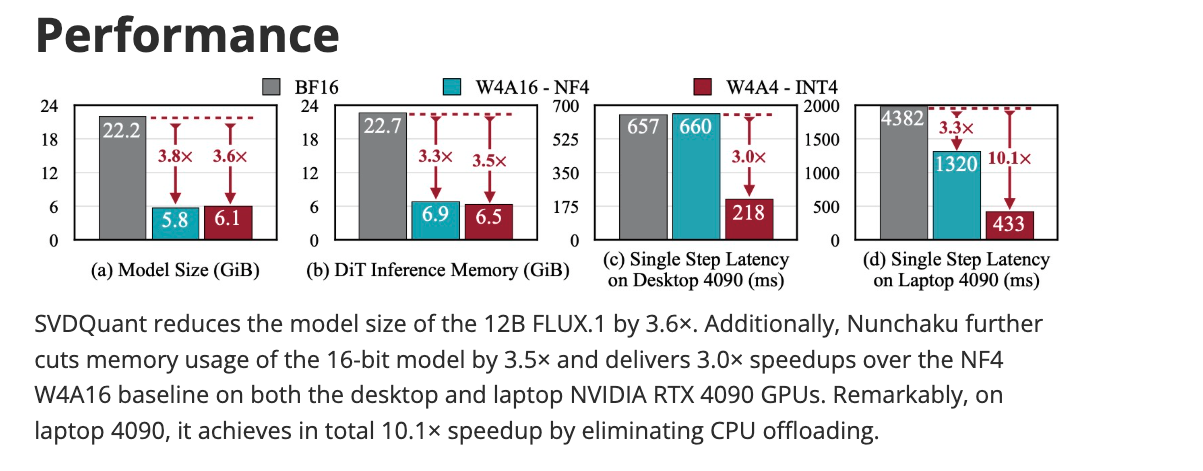